In [1]:
from src.topology.node import Node
from src.protocol import Protocol
from src.message import Message
from src.kernel.timeline import Timeline
from src.components.optical_channel import ClassicalChannel, QuantumChannel
from src.components.detector import PulseDetector
from src.components.light_source import ParametricSource
from src.kernel.event import Event
from src.kernel.process import Process
from enum import Enum, auto
from matplotlib import pyplot as plt
import numpy as np
from scipy.fft import fft, ifft

class MsgType(Enum):
    STOP = auto()

tl = Timeline(1e12)

In [2]:
# Parameters
# Detector_parameters
collection_probability = 0.64
dark_count_rate = 1e7 # 100
dead_time = 200
time_resolution = 50

# Optical channel
quantum_channel_attenuation = 0.44
classical_channel_attenuation = 0.5
distance = 2
raman_coefficient = 33 * 10e-10
polarization_fidelity = 1
light_speed = 3e8
max_rate = 1e12
quantum_channel_wavelength = 1536
classical_channel_wavelength = 1610

# Light Source
wavelength = quantum_channel_wavelength
mean_photon_num = 0.05
is_distinguishable = True
pulse_separation = 5e3
pulse_width = 80

# Clock parameters
clock_power = 0.0003
narrow_band_filter_bandwidth = 0.03

In [3]:
class RamanTestSender(Protocol):
    def __init__(self, own: Node):
        self.own = own
        # own.protocols.append(self)
        # self.other_nodes = other_nodes

    def start(self):
        # self.own.qchannels[self.own.signal_receiver].start_clock(clock_power, narrow_band_filter_bandwidth)

        for i in range(1000000):
            temp_time = self.emit_event()
            if not temp_time == None:
                emit_time = temp_time

        new_msg = Message(MsgType.STOP, self.own.signal_receiver)

        process = Process(self.own, "send_message", [self.own.signal_receiver, new_msg])
        event = Event(emit_time + 2000, process)
        self.own.timeline.schedule(event)
        # self.own.send_message(self.own.signal_receiver, new_msg)

    def emit_event(self):
        return self.own.parametric_source.emit()

    def received_message(self, src: str, message: Message):
        pass


class RamanTestReceiver(Protocol):
    def __init__(self, signal_node, idler_node, other_node: str):
        # signal_node.protocols.append(self)
        # idler_node.protocols.append(self)
        self.signal_node = signal_node
        self.idler_node = idler_node
        self.other_node = other_node
        self.first_detection = True
        self.first_detection_time = 0
        self.coincidence_times = []
        self.stop_receiving = False
        self.last_detection = 0

        self.half_hist_bin_width = int(pulse_separation/20)
        self.num_hist_bins_half = 45

        self.signal_buffer = []
        self.idler_buffer = []

    def start(self):
        # start clock and emissions
        pass

    def trigger(self, receiving_node_detector, time_dict):

        if self.stop_receiving:
            return
        
        detection_time = time_dict['time']
        
        # print(f"Received_detection at {detection_time}")

        receiving_node = receiving_node_detector.own


        if receiving_node == self.signal_node:
            self.signal_buffer.append(detection_time)
        
        if receiving_node == self.idler_node:
            self.idler_buffer.append(detection_time)

        
        # if receiving_node == self.signal_node:
        #     # print("photon received at signal node")
        #     try:
        #         while detection_time -  self.idler_buffer[0] > self.half_hist_bin_width * self.num_hist_bins_half:
        #             del self.idler_buffer[0]
        #     except:
        #         # print("empty idler buffer encountered. ignored")
        #         pass
        #     self.signal_buffer.append(detection_time)
        #     for i in self.idler_buffer:
        #         self.coincidence_times.append(-(detection_time - i))

        #     try:
        #         if detection_time == self.idler_buffer[-1]:
        #             self.coincidence_times.append(0)
        #     except:
        #         pass

        # if receiving_node == self.idler_node:
        #     # print("photon received at idler node")
        #     try:
        #         while detection_time -  self.signal_buffer[0] > self.half_hist_bin_width * self.num_hist_bins_half:
        #             del self.signal_buffer[0]
        #     except:
        #         # print("empty signal buffer encountered. ignored")
        #         pass
        #     self.idler_buffer.append(detection_time)
        #     for i in self.signal_buffer:
        #         self.coincidence_times.append((detection_time - i))

        #     try:
        #         if detection_time == self.signal_buffer[-1]:
        #             self.coincidence_times.append(0)
        #     except:
        #         pass




    def get_correlations(self, hist_width):
        last_detection_time = 0
        for i in self.signal_buffer:
            j = last_detection_time
            while j < len(self.idler_buffer) and self.idler_buffer[j] < i:
                j += 1
            last_detection_time = j
            while j < len(self.idler_buffer) and self.idler_buffer[j] < i + hist_width:
                self.coincidence_times.append(self.idler_buffer[j] - i)
                j += 1

        last_detection_time = 0
        for i in self.idler_buffer:
            j = last_detection_time
            while j < len(self.signal_buffer) and self.signal_buffer[j] < i:
                j += 1
            last_detection_time = j
            while j < len(self.signal_buffer) and self.signal_buffer[j] < i + hist_width:
                self.coincidence_times.append(i-self.signal_buffer[j])
                j += 1


    
    def received_message(self, src: str, message: Message):
        assert message.msg_type == MsgType.STOP
        self.stop_receiving = True
        self.get_correlations(self.half_hist_bin_width * self.num_hist_bins_half)
        
        n, bins, patches = plt.hist(self.coincidence_times, range(-self.half_hist_bin_width * self.num_hist_bins_half, self.half_hist_bin_width * self.num_hist_bins_half, self.half_hist_bin_width))# , range(-28125, 28126, 625)
        plt.yscale('log')
        plt.show()
        
        self.signal_node.timeline.stop()
        # print("finding correlations now")

        # # Required accuracy
        # delta_t = 1000

        # # Number of bins derrived from required accuracy
        # N = int((self.signal_receiving_times[-1] - self.signal_receiving_times[0])/delta_t)

        # # Wrap input data around N by placing the inputs in corresponding bins
        # a_k = [(t/delta_t)%N for t in self.signal_receiving_times]
        # b_k = [(t/delta_t)%N for t in self.idler_receiving_times]

        # # create buffers for running correlation function
        # buffer_1 = np.zeros(N)
        # buffer_2 = buffer_1.copy()

        # # Create input signals to find correlaions between
        # for i in a_k:
        #     buffer_1[int(i)] = 1

        # for i in b_k:
        #     buffer_2[int(i)] = 1

        # # Perform the correlation function
        # correlation = np.real(ifft(np.multiply(np.conjugate(fft(buffer_1)), fft(buffer_2))))

        # print("done with getting corrrelation vector")

        # plt.plot(correlation)

        # plt.show()

        

In [4]:
class receiver_node(Node):
    def __init__(self, name, timeline, sender_name):
        Node.__init__(self, name, timeline)
        self.detector = PulseDetector(self, name, timeline, collection_probability, dark_count_rate, dead_time, time_resolution)
        self.detector.owner = self
    
    def attach_detector_to_receiver(self, protocol):
        self.detector.attach(protocol)
        self.protocol = protocol

    def receive_message(self, src: str, msg: "Message"):
        self.protocol.received_message(src, msg)

    def receive_qubit(self, src, qubit):
        self.detector.get(qubit)

class sender_node(Node):
    def __init__(self, name, timeline):
        Node.__init__(self, name, timeline)
        self.protocol = RamanTestSender(self)


    def attach_lightsource_to_receivers(self, signal_receiver, idler_receiver):
        self.parametric_source = ParametricSource(self, None, self.timeline, signal_receiver, 
                                                  idler_receiver,wavelength, mean_photon_num, is_distinguishable, pulse_separation, pulse_width)
        self.signal_receiver = signal_receiver
        self.idler_receiver = idler_receiver
        # self.parametric_source.own = self
        # self.spdc_source.attach(self.protocol)

In [5]:
sender = sender_node("sender", tl)
signal_receiver = receiver_node("signal_receiver", tl, 'sender')
idler_receiver = receiver_node("idler_receiver", tl, 'sender')

In [6]:
receiver_protocol = RamanTestReceiver(signal_receiver, idler_receiver, 'sender')

signal_receiver.attach_detector_to_receiver(receiver_protocol)
idler_receiver.attach_detector_to_receiver(receiver_protocol)
sender.attach_lightsource_to_receivers("signal_receiver", "idler_receiver")

In [7]:
import traceback
import sys
try:
    signal_channel = QuantumChannel("signal_channel", tl, quantum_channel_attenuation, classical_channel_attenuation, distance, raman_coefficient, 
                                    polarization_fidelity, light_speed, max_rate, quantum_channel_wavelength, classical_channel_wavelength)
    idler_channel = QuantumChannel("idler_channel", tl, quantum_channel_attenuation, classical_channel_attenuation, distance, raman_coefficient, 
                                    polarization_fidelity, light_speed, max_rate, quantum_channel_wavelength, classical_channel_wavelength)
    classical_channel = ClassicalChannel("classical_channel", tl, distance)
    signal_channel.set_ends(sender, "signal_receiver")
    idler_channel.set_ends(sender, "idler_receiver")
    classical_channel.set_ends(sender, "signal_receiver")
except Exception:
    print(traceback.format_exc())

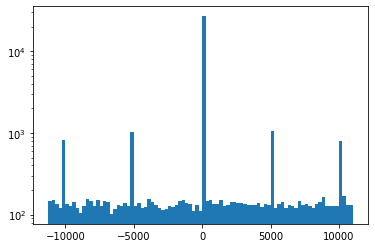

In [8]:
try:
    process = Process(sender.protocol, "start", [])
    event = Event(0, process)
    tl.schedule(event)

    tl.init()
    tl.run()

    # print(signal_receiver.protocol.coincidence_times)
    
    # n, bins, patches = plt.hist(signal_receiver.protocol.detection_times, range(-28125, 28126, 6250))
    # plt.show()    
except Exception:
    print(traceback.format_exc())

In [9]:
import numpy as np
half_hist_bin_width = 20
num_hist_bins_half = 1
receiving_node = 1
signal_node = 1
detection_times = [1,4,5,9,10,20,25,30,45,50,52,57,60,67,70,72,80,88,90,95,102,105,110,116]
coincidence_times = []
idler_buffer = np.array([])
last_detection = 0

# print("photon received at signal node")
for detection_time in detection_times:
    if receiving_node == signal_node:
        for i in idler_buffer:
            coincidence_times.append(-(detection_time - i))

    # idler_buffer += detection_time - last_detection
    # self.signal_mode += detection_time - self.last_detection

    try:
        while detection_time -  idler_buffer[-1] > half_hist_bin_width * num_hist_bins_half:
            del idler_buffer[-1]
    except:
        print("empty idler buffer encountered. ignored")
        

    print("detection_time:", detection_time)
    print("idler_buffer", idler_buffer)
    print("coincidence_times", coincidence_times)

# while detection_time -  self.signal[-1] > self.half_hist_bin_width * self.num_hist_bins_half:
#     del self.signal[-1]

empty idler buffer encountered. ignored
detection_time: 1
idler_buffer []
coincidence_times []
empty idler buffer encountered. ignored
detection_time: 4
idler_buffer []
coincidence_times []
empty idler buffer encountered. ignored
detection_time: 5
idler_buffer []
coincidence_times []
empty idler buffer encountered. ignored
detection_time: 9
idler_buffer []
coincidence_times []
empty idler buffer encountered. ignored
detection_time: 10
idler_buffer []
coincidence_times []
empty idler buffer encountered. ignored
detection_time: 20
idler_buffer []
coincidence_times []
empty idler buffer encountered. ignored
detection_time: 25
idler_buffer []
coincidence_times []
empty idler buffer encountered. ignored
detection_time: 30
idler_buffer []
coincidence_times []
empty idler buffer encountered. ignored
detection_time: 45
idler_buffer []
coincidence_times []
empty idler buffer encountered. ignored
detection_time: 50
idler_buffer []
coincidence_times []
empty idler buffer encountered. ignored
dete

In [10]:
signal_buffer = [1, 2, 4, 6, 8, 10, 11, 13, 16, 20, 23, 25]
idler_buffer = [0, 3, 5, 7, 10, 15, 16, 17, 20, 27]
hist_width = 5
coincidence_times = []

last_detection_time = 0
for i in signal_buffer:
    j = last_detection_time
    while j < len(idler_buffer) and idler_buffer[j] < i:
        j += 1
    last_detection_time = j
    while j < len(idler_buffer) and idler_buffer[j] < i + hist_width:
        coincidence_times.append(idler_buffer[j] - i)
        j += 1

last_detection_time = 0
for i in idler_buffer:
    j = last_detection_time
    while j < len(signal_buffer) and signal_buffer[j] < i:
        j += 1
    last_detection_time = j
    while j < len(signal_buffer) and signal_buffer[j] < i + hist_width:
        coincidence_times.append(i-signal_buffer[j])
        j += 1
print(coincidence_times)

[2, 4, 1, 3, 1, 3, 1, 4, 2, 0, 4, 2, 3, 4, 0, 1, 4, 0, 4, 2, -1, -2, -4, -1, -3, -1, -3, -1, -3, -4, 0, -1, -3, -1, 0, -4, -3, 0, -3]
